In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Currently data is in directories like

In [3]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#########################################################
# With this the whole file structure had to be changed.
# TODO Use code for test train split, currently the last 10 or so files are used as test, not randomly
#   For test/train split
#       get list of positives and negatives, test/train split the list.
#       move all filenames in that list to either test, or train directory
#########################################################

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        #rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        shear_range=0.2,
        zoom_range=[1,4],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

img = load_img('TrainingImages/positives/positivePatch_304.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (51, 51, 3)
x = x.reshape((1,) + x.shape)  # np array with shape (1, 51, 51, 3)

# Save example images if you want to see whats happening inside
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='TrainingImages', save_prefix='augmented', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Using TensorFlow backend.


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
batch_size = 16 # TODO find out what batch_size is

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        shear_range=0.2,
        zoom_range=[1,4],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'TrainingImages/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 51x51
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

Found 2830 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


In [6]:
# TODO search more about these hyperparameters
# steps_per_epoch???? 

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=4,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
#model.save_weights('augmentedCNN.h5')  # Maybe save if I find out how to load


Epoch 1/4
125/125 [==============================] - 12s 96ms/step - loss: 0.1234 - accuracy: 0.9660 - val_loss: 0.0822 - val_accuracy: 0.9886
Epoch 2/4
125/125 [==============================] - 12s 95ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 2.1806e-06 - val_accuracy: 1.0000
Epoch 3/4
125/125 [==============================] - 12s 92ms/step - loss: 0.0016 - accuracy: 0.9990 - val_loss: 4.1195e-07 - val_accuracy: 1.0000
Epoch 4/4
125/125 [==============================] - 12s 99ms/step - loss: 0.0118 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9899


# Classifier is trained
Now the classifier has been sufficiently trained we can use it on the pacman data

1 - First I will define the functions I created for the task

2 - Then I will use the PacMan code to play the game 

In [123]:

############### OLD BUT KEPT FOR REFERENCE #####################
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle
        for x in range (0, image_width-window_size, step_size):   #horizontal
            windows.append(image[y:y+window_size, x:x+window_size, :])
    print('Number of windows: {}'.format(len(windows)))

    return np.array(windows) # Return windows as np array

# This function is an extention of the sliding_window function
# The function takes in
# Prints 
# Returns the x,y coordinates of all the possible spheres ?????  
def sliding_window_classifier( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []    # Dont do anything with windows ?
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here we want the (x,y) coordinates and this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3) # MIGHT get not np error
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            if (prediction > 0.3):
                # SECTION FOR DEBUGGING PURPOSES
                #print('Coordinates: X:{}, Y:{}'.format(x,y))
                print('Prediction percentage: {} \n'.format(prediction))   #
                print('Middle pixel Depth: {}'.format(depth[y+26, x+26]))   # TODO call depth as a parameter or ensure it is correct
                # Find depth look at the middle

                # 26 IS MIDDLE PIXEL
                #TODO Draw a rectangle over these                 
                print('Middle 4:')
                print(depth[ y+25:y+27, x+25:x+27 ])    # IS THIS IN THE MIDDLE OR OF TO THE SIDE
                                                        # GET MIN/MODE OF THIS
                print('Middle 8:')
                print(depth[ y+24:y+28, x+24:x+28 ])    # IS THIS IN THE MIDDLE OR OF TO THE SIDE
                                                        # GET MIN/MODE OF THIS
                plt.figure(figsize=(8,4))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
                from matplotlib.patches import Rectangle
                ax=plt.gca()    # gca=get_current_axes?
 

                # Middle 4      1x1 either side
                ax.add_patch(Rectangle((24,24), width=2, height=2,linewidth=1,edgecolor='g',facecolor='none'))  
                # Middle 16     2x2 either side
                ax.add_patch(Rectangle((23,23), width=4, height=4,linewidth=1,edgecolor='y',facecolor='none')) 
                # Middle 36     3x3 either side
                ax.add_patch(Rectangle((22,22), width=6, height=6,linewidth=1,edgecolor='g',facecolor='none'))
                # Middle 64     4x4 either side
                ax.add_patch(Rectangle((21,21), width=8, height=8,linewidth=1,edgecolor='y',facecolor='none'))  

                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                #ax.xaxis.set_ticks([])
                #ax.yaxis.set_ticks([])  # Remove ticks
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                plt.figure(figsize=(4,2))
                plt.title('Depth')
                plt.imshow( depth[y:y+51, x:x+51] )    
                plt.colorbar()
                plt.show()
                print('########################################')
                print()
                # SECTION FOR DEBUGGING PURPOSES

                middle_depth = depth[y+25, x+25]

                if (prediction > 0.99): # Need to be at least 99% to add to list
                    result.append( (x, y, prediction, middle_depth) )
                    #return (x,y)    # WILL ONLY PRINT FIRST ONE TODO PRINT VECTOR OF x,y s

    # Results are np array with columns: X, Y, Prediction
    return np.asarray(result)#np.concatenate(result).reshape(-1,4)    # If len(coordinates)==0 then no spheres were found
# TODO WITH ABOVE MOVE TO HIGHEST PREDICITION, THEN CLOSEST BALL
# Maybe use pandas for that too

# Not for task but function to nicely visualise allmaps
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()


# This will change a lot
# First draft here to make code less messy
def sphere_position(x, y, cur_position, spheres_collected):
    # x,y
    # Given coordinates of sphere, 
    #   find x, y, z of sphere
    #   set that as position

    # For now going with move to middle pixel

    newx = mapx[x+25, y+25] #-0.2603576553033593
    newy = mapy[x+25, y+25] #0.04575819465891324
    newz = mapz[x+25, y+25] #2.330109222847228

    newx = np.round(newx, decimals=2) #-0.26
    newy = np.round(newy, decimals=2) #0.04
    newz = np.round(newz, decimals=2) #2.33

    print('I am at position [{0}, {1}, {2}]'.format(*cur_position))
    print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

    # Move position and update scene
    position = np.asarray([newx, newy, newz])
    print('I am now at position [{0}, {1}, {2}]'.format(*position))
    global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
    print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

    #print([newx, newy, newz])

    return np.asarray([newx, newy, newz])

In [107]:
%%time  # 1.11s
# Initilise game
import PacMan_functionality as PacMan
global_cloud, spheres_collected = PacMan.startup_scene()    # Have to use subsample, it effects acuracy but its way too slow otherwise
position = np.asarray([0, 0, 0])
angle = np.asarray([0, 0, 0])

Wall time: 1.11 s


In [108]:
%%time  # 5min 41s
# Obtain image and associated maps
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

Wall time: 5min 41s


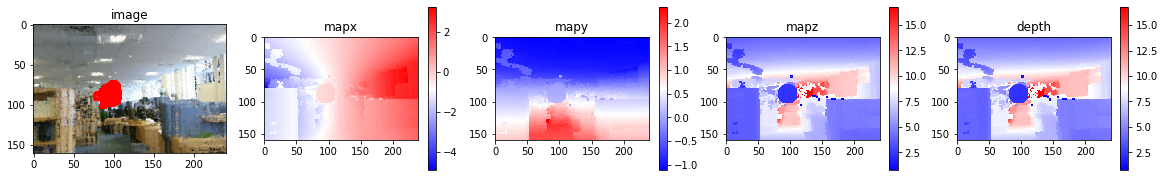


Prediction percentage: 0.4723835587501526 

Middle pixel Depth: 7.651873284564893
Middle 4:
[[ 7.53157664 10.72177291]
 [ 7.52564216  7.65187328]]
Middle 8:
[[10.50764072 10.50764072 10.50764072 10.55606611]
 [ 7.51296864  7.53157664 10.72177291  7.53121084]
 [ 7.51296864  7.52564216  7.65187328  7.50611087]
 [ 7.51296864  7.52564216  7.63368742  7.50611087]]


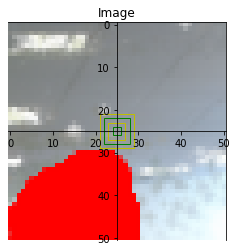

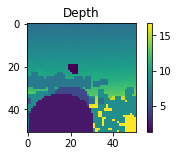

########################################

Prediction percentage: 1.0 

Middle pixel Depth: 2.3377300461956123
Middle 4:
[[2.34505627 2.33846136]
 [2.34416108 2.33773005]]
Middle 8:
[[2.3535933  2.34602651 2.34018818 2.33494503]
 [2.35251468 2.34505627 2.33846136 2.33351922]
 [2.351512   2.34416108 2.33773005 2.33282271]
 [2.351512   2.34416108 2.33773005 2.33282271]]


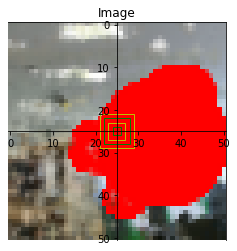

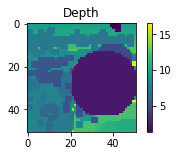

########################################

Prediction percentage: 0.9999500513076782 

Middle pixel Depth: 2.3438515527050674
Middle 4:
[[2.33835639 2.34385155]
 [2.33741109 2.34385155]]
Middle 8:
[[2.33439055 2.33937939 2.34610875 2.35359586]
 [2.33259903 2.33835639 2.34385155 2.35234047]
 [2.33259903 2.33741109 2.34385155 2.35113231]
 [2.33259903 2.33741109 2.34385155 2.35113231]]


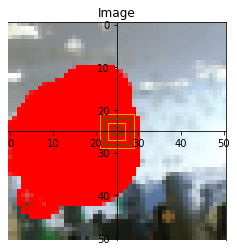

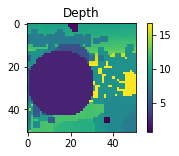

########################################

[[60.         60.          1.          2.34505627]
 [80.         60.          0.99995005  2.33835639]]
I am at position [0, 0, 0]
I have found 1 out of 11 spheres!

I am now at position [-1.05, 0.74, 9.44]
I have found 1 out of 11 spheres!

Wall time: 5.38 s


In [129]:
%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    

position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [133]:
%%time
# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

Wall time: 41 s


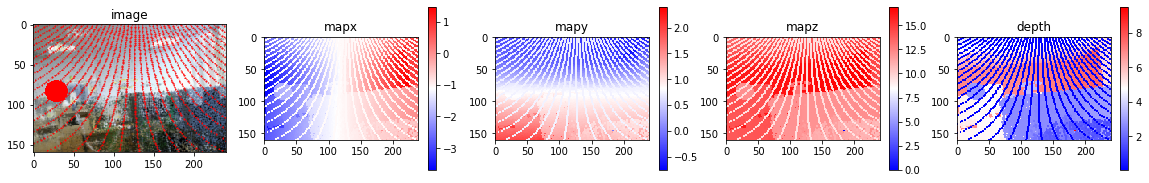


Prediction percentage: 0.8373623490333557 

Middle pixel Depth: 0.0979562244940802
Middle 4:
[[6.95124681 0.09795622]
 [0.0964786  0.09795622]]
Middle 8:
[[6.95618741 6.95347487 0.09795622 0.09795622]
 [6.95577353 6.95124681 0.09795622 0.09795622]
 [0.0964786  0.0964786  0.09795622 0.09795622]
 [0.0964786  0.0964786  6.94387477 6.94149921]]


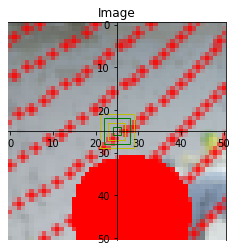

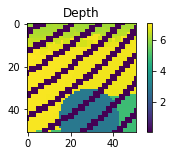

########################################

Prediction percentage: 1.0 

Middle pixel Depth: 2.864174504376046
Middle 4:
[[2.86518216 2.86407684]
 [2.86532394 2.8641745 ]]
Middle 8:
[[2.86699522 2.86518216 2.86407684 2.86359988]
 [2.86699522 2.86518216 2.86407684 2.86359988]
 [2.8670951  2.86532394 2.8641745  2.86368895]
 [2.86797653 2.86608527 2.86494635 2.86445429]]


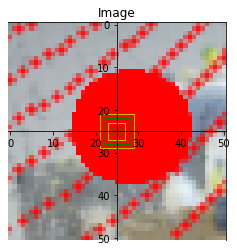

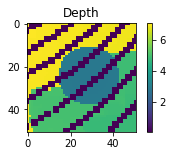

########################################

[[ 0.         60.          1.          2.86518216]]
I am at position [-1.05, 0.74, 9.44]
I have found 1 out of 11 spheres!

I am now at position [-1.34, 0.95, 12.05]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [134]:
%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
x = int(npres[min_index, 0])    # From float to int
y = int(res[min_index, 1])    

sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [0]:
# Move to next sphere and update

In [0]:
#

In [0]:
#

In [0]:
#

In [0]:
#
#

In [0]:
#

In [0]:
#